In [1]:
import pandas as pd
import numpy as np
import os

os.listdir('./')

['.ipynb_checkpoints',
 '300전사들.pptx',
 'Cluster0_modeling.ipynb',
 'Cluster1_modeling.ipynb',
 'cluster_df.csv',
 'Cluster_modeling_sohyun.ipynb',
 'final_modeling1.ipynb',
 'final_modeling2.ipynb',
 'test.csv',
 'train.csv']

In [2]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
cluster_df = pd.read_csv('./cluster_df.csv')
train['train'] = 1
test['train'] = 0

df = pd.concat([train, test])
df = pd.merge(df, cluster_df, how = 'left')
df.shape

(1489618, 44)

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [241]:
df.cluster.value_counts()

2    760052
0    659526
1     70040
Name: cluster, dtype: int64

In [4]:
from sklearn.preprocessing import LabelEncoder

lb_make = LabelEncoder()
df["days"] = lb_make.fit_transform(df["days"])
df["direction"] = lb_make.fit_transform(df["direction"])
df["road_type"] = lb_make.fit_transform(df["road_type"])
df["urban_suburb"] = lb_make.fit_transform(df["urban_suburb"])
df["district"] = lb_make.fit_transform(df["district"])
df["time"] = lb_make.fit_transform(df["time"])

In [5]:
def rain_level(rain) :
    if rain >= 30 :
        return 3
    else :
        if rain >=15 :
            return 2
        else :
            if rain >=3 :
                return 1
            else : return 0

def dust_PM2_level(dust) :
    if dust >= 76 :
        return 3
    else :
        if dust >=36 :
            return 2
        else :
            if dust >=16 :
                return 1
            else : return 0      

def dust_PM10_level(dust) :
    if dust >= 151 :
        return 3
    else :
        if dust >=81 :
            return 2
        else :
            if dust >=31 :
                return 1
            else : return 0

def wind_level(wind) :
    if wind >= 14 :
        return 3
    else :
        if wind >=9 :
            return 2
        else :
            if wind >=4 :
                return 1
            else : return 0

def O3_level(O3) :
    if O3 >= 0.151 :
        return 3
    else :
        if O3 >=0.091 :
            return 2
        else :
            if O3 >=0.031 :
                return 1
            else : return 0
            
df['dust_PM10_level'] = df['PM10'].apply(lambda x : dust_PM10_level(x))
df['dust_PM2_level'] = df['PM2.5'].apply(lambda x : dust_PM2_level(x))
df['rain_level'] = df['rain'].apply(lambda x : rain_level(x))       
df['wind_level'] = df['wind'].apply(lambda x : wind_level(x))            
df['O3_level'] = df['O3'].apply(lambda x : O3_level(x))

In [6]:
df['hsv'] = df['holiday'] + df['special'] + df['vacation']
df['cctv_kids'] = df['cctv'] + df['kids']

df['cctv_length'] = df['cctv'] / df['road_length']
df['kids_length'] = df['kids'] / df['road_length']
df['entrance_length'] = df['entrance'] / df['road_length']
df['signal_length'] = df['signal'] / df['road_length']

df['cctv_num'] = df['cctv'] / df['inter_num']
df['kids_num'] = df['kids'] / df['inter_num']
df['entrance_num'] = df['entrance'] / df['inter_num']
df['signal_num'] = df['signal'] / df['inter_num']

bins = [0,500,1000,1500,2000,4000]
bins_names = [0,1,2,3,4] # 구간별 이름
df['severity_level'] = pd.cut(df['severity'], bins, labels=bins_names)

bins = [-40,-10,10,20,30,50]
bins_names = [0,1,2,3,4] # 구간별 이름
df['temp_level'] = pd.cut(df['temperature'], bins, labels=bins_names)

In [7]:
cols = ['days','time','road_type','month','temp_level','rain_level','dust_PM10_level',
       'dust_PM2_level', 'rain_level', 'wind_level', 'O3_level','severity_level']

df_dummy = pd.get_dummies(df, columns=cols)
df_dummy.shape

(1489618, 116)

In [8]:
df = pd.concat([df_dummy, df[cols]], axis = 1)
df.shape

(1489618, 128)

In [9]:
cols = ['d1', 'd2', 'd3', 'd4','victims', 'severity', 'accident_count']

for col in cols :
    df[col + '_length'] = df[col] / df['road_length']
    df[col + '_num'] = df[col] / df['inter_num']

In [10]:
def seasonal(month) :
    if (month <= 5) & (month >= 3):
        return 0
    elif (month >= 6) & (month >= 8):
        return 1
    elif (month >= 9) & (month >= 11):
        return 2
    else :
        return 3
df['season'] = df['month'].apply(lambda x : seasonal(x))

# Cluster 1

In [11]:
c1 = df[df.cluster == 1]
c1.shape

(70040, 143)

In [12]:
c1 = c1.drop(['date','road_name','link_id','start_point','end_point'],axis = 1)
c1.drop(c1.var().index[c1.var() == 0],axis = 1, inplace = True)
c1 = c1.reset_index(drop = True)

train = c1[c1.train == 1]
test = c1[c1.train == 0]

print('train shape : ', train.shape)
print('test shape : ', test.shape)

train shape :  (49099, 129)
test shape :  (20941, 129)


In [13]:
col_mask=c1.isnull().any(axis=0) 
row_mask=c1.isnull().any(axis=1)

c1.loc[row_mask,col_mask]

""


In [14]:
X_train = train.drop(['y', 'train'], axis = 1)
y_train = train.y

X_test = test.drop(['y','train'], axis = 1)
y_test = test.y

print((X_train.shape, X_test.shape), (y_train.shape, y_test.shape))

((49099, 127), (20941, 127)) ((49099,), (20941,))


In [15]:
from sklearn.metrics import mean_squared_error

def rmse(y_true, y_pred) : 
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [105]:
def rmse_print(model) :
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print('{0} test rmse : {1:.3f}'.format(model.__class__.__name__, rmse(y_test, y_pred)))

In [16]:
def model_cv_test(model, train_X, train_y, test_X, test_y, is_log) :

    train_rmse = []
    valid_rmse = []
    
    print('##### {} #####'.format(model.__class__.__name__))
        
    for i, (train_idx, val_idx) in enumerate(kf.split(train_X)):
        X_train, X_val = train_X.iloc[train_idx, :], train_X.iloc[val_idx, :]
        y_train, y_val = train_y[train_idx], train_y[val_idx]

        model.fit(X_train, y_train)
        
        if is_log :
            y_train = np.expm1(y_train)
            y_val = np.expm1(y_val)
            pred_train = np.expm1(model.predict(X_train))
            pred_valid = np.expm1(model.predict(X_val))
        else :
            pred_train = model.predict(X_train)
            pred_valid = model.predict(X_val)

        print('{0} fold train rmse : {1:.3f} valid rmse : {2:.3f}'.format(i, rmse(y_train, pred_train), rmse(y_val, pred_valid)))
        
        train_rmse.append(rmse(y_train, pred_train))
        valid_rmse.append(rmse(y_val, pred_valid))

    print('\n')    
    print('mean train rmse : {0:.3f} mean valid rmse : {1:.3f}'.format(np.mean(train_rmse), np.mean(valid_rmse)))

    
    model.fit(train_X, train_y)
    
    if is_log :
        test_y = np.expm1(test_y)
        pred_test = np.expm1(model.predict(test_X))
    else :
        pred_test = model.predict(test_X)
    
    print('test rmse {0:.3f} '.format(rmse(test_y, pred_test)))

In [17]:
from sklearn.model_selection import KFold
kf = KFold(n_splits = 3, random_state = 333)

# OLS

In [223]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
lr = LinearRegression()

In [253]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

sc.fit(X_train)
X_train_sc = pd.DataFrame(sc.transform(X_train))
X_test_sc = pd.DataFrame(sc.transform(X_test))

In [254]:
model_cv_test(lr, X_train_sc, y_train, X_test_sc, y_test, False)

##### LinearRegression #####
0 fold train rmse : 13.231 valid rmse : 13.210
1 fold train rmse : 13.166 valid rmse : 13.304
2 fold train rmse : 13.223 valid rmse : 13.190


mean train rmse : 13.207 mean valid rmse : 13.235
test rmse 13.220 


In [259]:
model_cv_test(lr, X_train, y_train, X_test, y_test, False)

##### LinearRegression #####
0 fold train rmse : 13.215 valid rmse : 13.199
1 fold train rmse : 13.164 valid rmse : 13.300
2 fold train rmse : 13.223 valid rmse : 13.189


mean train rmse : 13.201 mean valid rmse : 13.230
test rmse 13.215 


# Ridge

In [258]:
ridge = Ridge()
model_cv_test(ridge, X_train_sc, y_train, X_test_sc, y_test, False)

##### Ridge #####
0 fold train rmse : 14.518 valid rmse : 14.537
1 fold train rmse : 14.469 valid rmse : 14.634
2 fold train rmse : 14.549 valid rmse : 14.467


mean train rmse : 14.512 mean valid rmse : 14.546
test rmse 14.494 


In [262]:
model_cv_test(ridge, X_train, y_train, X_test, y_test, False)

##### Ridge #####
0 fold train rmse : 14.609 valid rmse : 14.634
1 fold train rmse : 14.560 valid rmse : 14.730
2 fold train rmse : 14.649 valid rmse : 14.554


mean train rmse : 14.606 mean valid rmse : 14.639
test rmse 14.609 


In [264]:
from sklearn.model_selection import cross_val_score

In [266]:
cv = KFold(n_splits = 3, random_state = 333)

In [268]:
from bayes_opt import BayesianOptimization

In [274]:
def RidgeCV(alpha) :
    ridge = Ridge(alpha = alpha)
    rmse = np.sqrt(-cross_val_score(ridge, X_train,y_train, scoring = 'neg_mean_squared_error', cv = cv))
    return -rmse.mean()

In [275]:
pbounds = {'alpha' : (0,10)}

Ridge_Bo = BayesianOptimization(f = RidgeCV, pbounds = pbounds, verbose = 2, random_state = 1)
Ridge_Bo.maximize()

|   iter    |  target   |   alpha   |
-------------------------------------
|  1        | -14.64    |  4.17     |
|  2        | -14.64    |  7.203    |
|  3        | -14.48    |  0.001144 |
|  4        | -14.64    |  3.023    |
|  5        | -14.64    |  1.468    |
|  6        | -14.64    |  10.0     |


c:\users\user\appdata\local\programs\python\python35\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 5.656356254025902e-50
  ' condition number: {}'.format(rcond), RuntimeWarning)
c:\users\user\appdata\local\programs\python\python35\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.1450943548984894e-78
  ' condition number: {}'.format(rcond), RuntimeWarning)
c:\users\user\appdata\local\programs\python\python35\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.3963537764739438e-49
  ' condition number: {}'.format(rcond), RuntimeWarning)


|  7        | -4.726e+7 |  0.0      |
|  8        | -14.64    |  4.17     |
|  9        | -14.64    |  3.023    |
|  10       | -14.64    |  3.023    |
|  11       | -14.64    |  4.17     |
|  12       | -14.64    |  3.023    |
|  13       | -14.64    |  10.0     |
|  14       | -14.48    |  0.001157 |
|  15       | -14.64    |  7.203    |
|  16       | -14.64    |  1.468    |
|  17       | -14.64    |  1.468    |
|  18       | -14.64    |  1.468    |
|  19       | -14.48    |  0.001155 |
|  20       | -14.48    |  0.001156 |
|  21       | -14.64    |  3.023    |
|  22       | -14.48    |  0.001151 |
|  23       | -14.64    |  10.0     |
|  24       | -14.64    |  4.17     |
|  25       | -14.64    |  4.17     |
|  26       | -14.64    |  1.468    |
|  27       | -14.64    |  4.17     |
|  28       | -14.48    |  0.001144 |
|  29       | -14.64    |  10.0     |
|  30       | -14.64    |  10.0     |


In [276]:
Ridge_Bo.max

{'params': {'alpha': 0.0011437481734488664}, 'target': -14.475294294815404}

In [277]:
ridge = Ridge(alpha=Ridge_Bo.max['params']['alpha'])
model_cv_test(ridge, X_train_sc, y_train, X_test_sc, y_test, False)

##### Ridge #####
0 fold train rmse : 13.239 valid rmse : 13.222
1 fold train rmse : 13.188 valid rmse : 13.326
2 fold train rmse : 13.246 valid rmse : 13.211


mean train rmse : 13.224 mean valid rmse : 13.253
test rmse 13.227 


In [278]:
ridge = Ridge(alpha=Ridge_Bo.max['params']['alpha'])
model_cv_test(ridge, X_train, y_train, X_test, y_test, False)

##### Ridge #####
0 fold train rmse : 14.450 valid rmse : 14.460
1 fold train rmse : 14.401 valid rmse : 14.557
2 fold train rmse : 14.472 valid rmse : 14.409


mean train rmse : 14.441 mean valid rmse : 14.475
test rmse 14.465 


# Lasso

In [261]:
lasso = Lasso()
model_cv_test(lasso, X_train_sc, y_train, X_test_sc, y_test, False)

##### Lasso #####
0 fold train rmse : 16.257 valid rmse : 16.323
1 fold train rmse : 16.234 valid rmse : 16.310
2 fold train rmse : 16.327 valid rmse : 16.204


mean train rmse : 16.273 mean valid rmse : 16.279
test rmse 16.325 


In [263]:
model_cv_test(lasso, X_train, y_train, X_test, y_test, False)

##### Lasso #####
0 fold train rmse : 16.682 valid rmse : 16.755
1 fold train rmse : 16.651 valid rmse : 16.749
2 fold train rmse : 16.739 valid rmse : 16.587


mean train rmse : 16.691 mean valid rmse : 16.697
test rmse 16.734 


In [279]:
def LassoCV(alpha) :
    lasso = Lasso(alpha = alpha)
    rmse = np.sqrt(-cross_val_score(lasso, X_train,y_train, scoring = 'neg_mean_squared_error', cv = cv))
    return -rmse.mean()

In [280]:
pbounds = {'alpha' : (0,10)}

Lasso_Bo = BayesianOptimization(f = LassoCV, pbounds = pbounds, verbose = 2, random_state = 1)
Lasso_Bo.maximize()

|   iter    |  target   |   alpha   |
-------------------------------------
|  1        | -17.87    |  4.17     |
|  2        | -18.0     |  7.203    |


c:\users\user\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\user\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\user\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


|  3        | -14.64    |  0.001144 |
|  4        | -17.74    |  3.023    |
|  5        | -17.06    |  1.468    |
|  6        | -15.6     |  0.4102   |
|  7        | -18.15    |  10.0     |


c:\users\user\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\user\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\user\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


|  8        | -14.75    |  0.08024  |


c:\users\user\appdata\local\programs\python\python35\lib\site-packages\sklearn\model_selection\_validation.py:238: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
c:\users\user\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:470: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  positive)
c:\users\user\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\user\appdata\local\programs\python\python35\lib\site-packages\sklearn\model_selection\_validation.py:238: UserWarning: With alpha=0, this algorithm does not converge well. Yo

|  9        | -14.64    |  0.0      |


c:\users\user\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\user\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\user\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


|  10       | -14.64    |  1.11e-16 |
|  11       | -14.64    |  1.11e-16 |


c:\users\user\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\user\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\user\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


|  12       | -14.64    |  8.496e-1 |
|  13       | -14.64    |  8.496e-1 |


c:\users\user\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\user\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\user\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


|  14       | -14.64    |  7.466e-0 |
|  15       | -14.64    |  7.466e-0 |


c:\users\user\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\user\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\user\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


|  16       | -14.64    |  2.993e-0 |


c:\users\user\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\user\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\user\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


|  17       | -14.64    |  1.193e-1 |
|  18       | -14.64    |  1.193e-1 |
|  19       | -14.64    |  1.193e-1 |
|  20       | -14.64    |  1.193e-1 |
|  21       | -14.64    |  1.193e-1 |
|  22       | -14.64    |  1.193e-1 |
|  23       | -14.64    |  1.193e-1 |


c:\users\user\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\user\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\user\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


|  24       | -14.64    |  6.627e-0 |
|  25       | -17.93    |  5.653    |


c:\users\user\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\user\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\user\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


|  26       | -14.64    |  4.108e-0 |
|  27       | -14.64    |  4.108e-0 |
|  28       | -14.64    |  4.108e-0 |
|  29       | -14.64    |  4.108e-0 |


c:\users\user\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\user\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


|  30       | -14.64    |  2.236e-0 |


c:\users\user\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [283]:
Lasso_Bo.max

{'params': {'alpha': 6.6272277229793909e-08}, 'target': -14.637983019429313}

In [284]:
lasso = Lasso(alpha=Lasso_Bo.max['params']['alpha'])
model_cv_test(lasso, X_train_sc, y_train, X_test_sc, y_test, False)
model_cv_test(lasso, X_train, y_train, X_test, y_test, False)

##### Lasso #####


c:\users\user\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0 fold train rmse : 14.607 valid rmse : 14.632
1 fold train rmse : 14.558 valid rmse : 14.728
2 fold train rmse : 14.647 valid rmse : 14.554


mean train rmse : 14.604 mean valid rmse : 14.638
test rmse 14.609 
##### Lasso #####
0 fold train rmse : 14.607 valid rmse : 14.632
1 fold train rmse : 14.558 valid rmse : 14.728
2 fold train rmse : 14.647 valid rmse : 14.554


mean train rmse : 14.604 mean valid rmse : 14.638
test rmse 14.609 


# RandomForest

In [285]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_jobs = -1)

In [295]:
rf = RandomForestRegressor(n_jobs = -1, n_estimators=500)
model_cv_test(rf, X_train, y_train, X_test, y_test, False)

##### RandomForestRegressor #####
0 fold train rmse : 3.057 valid rmse : 8.299
1 fold train rmse : 3.064 valid rmse : 8.324
2 fold train rmse : 3.083 valid rmse : 8.291


mean train rmse : 3.068 mean valid rmse : 8.304
test rmse 7.934 


# XGBoost

In [297]:
from xgboost import XGBRegressor
xgb = XGBRegressor(n_jobs = -1)

In [300]:
def model_cv_test2(model, train_X, train_y, test_X, test_y, is_log) :

    train_rmse = []
    valid_rmse = []
    
    print('##### {} #####'.format(model.__class__.__name__))
        
    for i, (train_idx, val_idx) in enumerate(kf.split(train_X)):
        X_train, X_val = train_X[train_idx, :], train_X[val_idx, :]
        y_train, y_val = train_y[train_idx], train_y[val_idx]

        model.fit(X_train, y_train)
        
        if is_log :
            y_train = np.expm1(y_train)
            y_val = np.expm1(y_val)
            pred_train = np.expm1(model.predict(X_train))
            pred_valid = np.expm1(model.predict(X_val))
        else :
            pred_train = model.predict(X_train)
            pred_valid = model.predict(X_val)

        print('{0} fold train rmse : {1:.3f} valid rmse : {2:.3f}'.format(i, rmse(y_train, pred_train), rmse(y_val, pred_valid)))
        
        train_rmse.append(rmse(y_train, pred_train))
        valid_rmse.append(rmse(y_val, pred_valid))

    print('\n')    
    print('mean train rmse : {0:.3f} mean valid rmse : {1:.3f}'.format(np.mean(train_rmse), np.mean(valid_rmse)))

    
    model.fit(train_X, train_y)
    
    if is_log :
        test_y = np.expm1(test_y)
        pred_test = np.expm1(model.predict(test_X))
    else :
        pred_test = model.predict(test_X)
    
    print('test rmse {0:.3f} '.format(rmse(test_y, pred_test)))

In [302]:
import warnings
warnings.filterwarnings('ignore')

In [303]:
xgb = XGBRegressor(n_jobs = -1, n_estimators = 5000)

In [304]:
model_cv_test2(xgb, X_train.values, y_train, X_test.values, y_test, False)

##### XGBRegressor #####
[23:43:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0 fold train rmse : 7.303 valid rmse : 8.875
[23:45:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
1 fold train rmse : 7.271 valid rmse : 8.854
[23:48:24] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
2 fold train rmse : 7.276 valid rmse : 8.765


mean train rmse : 7.284 mean valid rmse : 8.831
[23:50:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
test rmse 8.640 


# lightGBM

In [18]:
from lightgbm import LGBMRegressor
lgb = LGBMRegressor(n_jobs = -1)

In [312]:
model_cv_test(lgb, X_train, y_train, X_test, y_test, False)

##### LGBMRegressor #####
0 fold train rmse : 7.844 valid rmse : 8.451
1 fold train rmse : 7.911 valid rmse : 8.397
2 fold train rmse : 7.921 valid rmse : 8.343


mean train rmse : 7.892 mean valid rmse : 8.397
test rmse 8.237 


In [315]:
def lgbCV(learning_rate, n_estimators, num_leaves, colsample_bytree, subsample, reg_alpha,reg_lambda) :
    lgb = LGBMRegressor(learning_rate = learning_rate, colsample_bytree = colsample_bytree,
                        n_estimators = int(n_estimators), num_leaves = int(num_leaves),
                        subsample = subsample, reg_alpha = reg_alpha,reg_lambda = reg_lambda)
    
    rmse = np.sqrt(-cross_val_score(lgb, X_train,y_train, scoring = 'neg_mean_squared_error', cv = cv))
    return -rmse.mean()

In [317]:
pbounds = {
    'learning_rate': (0.001,1),
    'n_estimators': (20,1000),
    'num_leaves': (4,20),
    'colsample_bytree' : (0.1,0.7),
    'subsample' : (0.1,0.8),
    'reg_alpha' : (1,1.8),
    'reg_lambda' : (1,1.5)
    }

lgb_Bo = BayesianOptimization(f = lgbCV, pbounds = pbounds, verbose = 2, random_state = 1)
lgb_Bo.maximize()

|   iter    |  target   | colsam... | learni... | n_esti... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        | -10.76    |  0.3502   |  0.7206   |  20.11    |  8.837    |  1.117    |  1.046    |  0.2304   |
|  2        | -8.351    |  0.3073   |  0.3974   |  548.0    |  10.71    |  1.548    |  1.102    |  0.7147   |
|  3        | -8.835    |  0.1164   |  0.6708   |  429.0    |  12.94    |  1.112    |  1.099    |  0.6605   |
|  4        | -8.139    |  0.681    |  0.3141   |  698.5    |  18.02    |  1.716    |  1.043    |  0.1273   |
|  5        | -9.189    |  0.2019   |  0.8783   |  116.4    |  10.74    |  1.766    |  1.267    |  0.5843   |
|  6        | -9.262    |  0.1      |  1.0      |  805.4    |  4.0      |  1.0      |  1.5      |  0.8      |
|  7        | -9.347    |  0.1      |  1.0      |  628.1    |  4.0      |  1.0      |  1.5      |  0.8      |
|  8      

In [319]:
lgb_Bo.set_bounds(new_bounds = {'learning_rate' : (0.1,0.4), 'num_leaves' : (7,20)})
lgb_Bo.maximize()

|   iter    |  target   | colsam... | learni... | n_esti... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------
|  31       | -8.391    |  0.2893   |  0.306    |  837.9    |  7.238    |  1.6      |  1.494    |  0.6237   |
|  32       | -8.981    |  0.2683   |  0.3368   |  121.2    |  12.82    |  1.727    |  1.147    |  0.3014   |
|  33       | -9.084    |  0.178    |  0.1058   |  685.3    |  9.751    |  1.212    |  1.246    |  0.1374   |
|  34       | -8.133    |  0.4445   |  0.144    |  597.5    |  16.1     |  1.082    |  1.207    |  0.5861   |
|  35       | -8.304    |  0.3485   |  0.115    |  545.2    |  15.63    |  1.412    |  1.472    |  0.5106   |
|  36       | -8.442    |  0.1251   |  0.3656   |  780.8    |  12.57    |  1.346    |  1.244    |  0.3838   |
|  37       | -8.149    |  0.4786   |  0.1297   |  781.0    |  12.39    |  1.344    |  1.408    |  0.5407   |
|  38     

In [320]:
lgb_Bo.set_bounds(new_bounds = {'colsample_bytree' : (0.4,0.7), 'n_estimators' : (500,1000),
                               'num_leaves' : (15,20),'subsample' : (0.3,0.7)})
lgb_Bo.maximize()

|   iter    |  target   | colsam... | learni... | n_esti... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------
|  61       | -8.001    |  0.671    |  0.1412   |  569.6    |  19.04    |  1.318    |  1.083    |  0.671    |
|  62       | -8.166    |  0.5043   |  0.3252   |  863.0    |  19.42    |  1.499    |  1.375    |  0.4396   |
|  63       | -8.233    |  0.481    |  0.3688   |  714.0    |  19.82    |  1.531    |  1.311    |  0.3459   |
|  64       | -8.029    |  0.6848   |  0.235    |  789.2    |  17.04    |  1.19     |  1.452    |  0.5295   |
|  65       | -8.107    |  0.4009   |  0.2851   |  663.3    |  17.64    |  1.709    |  1.179    |  0.6634   |
|  66       | -8.062    |  0.7      |  0.1494   |  597.2    |  15.85    |  1.549    |  1.051    |  0.3677   |
|  67       | -8.231    |  0.7      |  0.4      |  597.3    |  15.68    |  1.287    |  1.121    |  0.7      |
|  68     

In [313]:
lgb = LGBMRegressor(n_jobs = -1, n_estimators = 500)
model_cv_test(lgb, X_train, y_train, X_test, y_test, False)

##### LGBMRegressor #####
0 fold train rmse : 5.987 valid rmse : 7.879
1 fold train rmse : 6.144 valid rmse : 7.883
2 fold train rmse : 6.055 valid rmse : 7.828


mean train rmse : 6.062 mean valid rmse : 7.863
test rmse 7.616 


In [321]:
lgb_Bo.max

{'params': {'colsample_bytree': 0.67102057458636499,
  'learning_rate': 0.14124241124387127,
  'n_estimators': 569.6381736253793,
  'num_leaves': 19.03695644354762,
  'reg_alpha': 1.3181414695884268,
  'reg_lambda': 1.0826770985584664,
  'subsample': 0.67100343215841352},
 'target': -8.0005599576949677}

In [323]:
lgb = LGBMRegressor(n_jobs = -1,colsample_bytree=lgb_Bo.max['params']['colsample_bytree'],
                    learning_rate=lgb_Bo.max['params']['learning_rate'],
                    n_estimators=570,
                    num_leaves=19,
                    reg_alpha=lgb_Bo.max['params']['reg_alpha'],
                    reg_lambda=lgb_Bo.max['params']['reg_lambda'],
                    subsample=lgb_Bo.max['params']['subsample'],
           )

model_cv_test(lgb, X_train, y_train, X_test, y_test, False)

##### LGBMRegressor #####
0 fold train rmse : 6.369 valid rmse : 7.990
1 fold train rmse : 6.374 valid rmse : 8.003
2 fold train rmse : 6.467 valid rmse : 8.007


mean train rmse : 6.403 mean valid rmse : 8.000
test rmse 7.756 


In [19]:
lgb = LGBMRegressor(n_jobs = -1,colsample_bytree=0.67102057458636499,
                    learning_rate=0.14124241124387127,
                    n_estimators=570,
                    num_leaves=19,
                    reg_alpha=1.3181414695884268,
                    reg_lambda=1.0826770985584664,
                    subsample=0.67100343215841352,
           )

lgb.fit(X_train, y_train)
lgb_pred = lgb.predict(X_test)

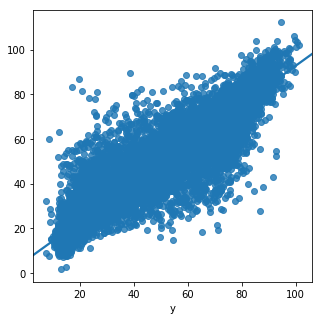

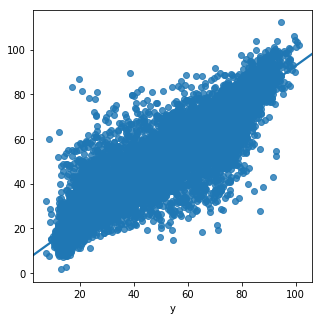

In [21]:
plt.figure(figsize = (5,5))
sns.regplot(y_test, lgb_pred)
plt.show()

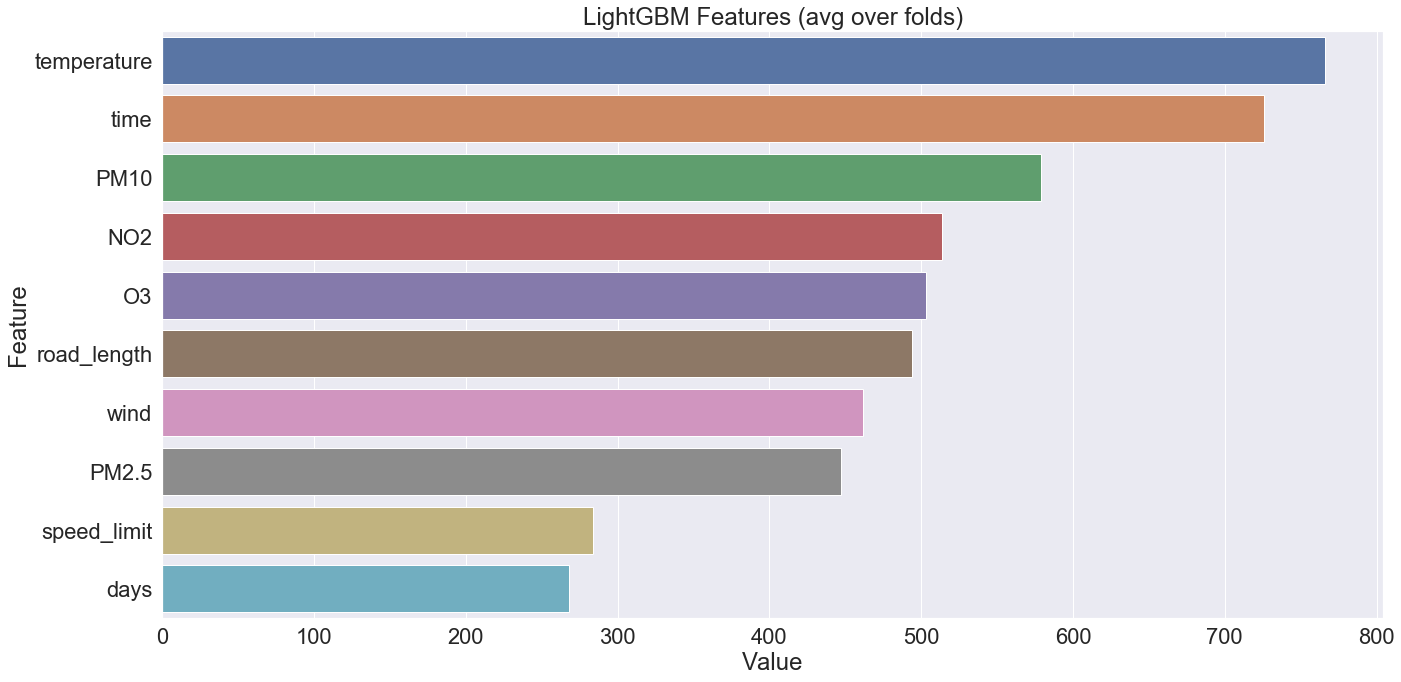

In [26]:
feature_imp = pd.DataFrame(sorted(zip(lgb.feature_importances_, X_train.columns)), columns=['Value','Feature'])

sns.set(font_scale = 2)
plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[:10])
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()